In [ ]:
pip install scikit-learn


In [2]:
from collections import Counter
import numpy as np
import pandas as pd
from requests import head
import seaborn as sns
import matplotlib.pyplot as plt 
import time
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib import colormaps
import matplotlib.animation as animation
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
import sys 
import os 

# Adicionando o diretório do projeto ao sys.path
project_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_path)

import utilities.utilities as u

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package shakespeare to nltk_data...
[nltk_data]    | 

In [19]:
import re

# Função de limpeza de texto
def preprocess_text(text):
    # Remover pontuação, números e símbolos especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Converter para minúsculas
    text = text.lower()
    return text

In [22]:
# df_clean = pd.read_csv('cleaned_data/dados_limpos.csv')
df_original = pd.read_csv('../data/fake_and_real_news.csv')

df_clean = pd.DataFrame({'Text': [], 'label': []})

df_clean['Text'] = df_original['Text'].apply(preprocess_text)

mapeamento = {'Real': 1, 'Fake': 0}
   
# cópia e escrita em disco da coluna 'label' normalizada para o dataframe que contém os dados limpos 
df_clean['label'] = df_original['label'].map(mapeamento)

df_clean.to_csv('../cleaned_data/cleaned_texts.csv', index=False)


In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import os
from wordcloud import WordCloud
from collections import Counter 
from itertools import repeat, chain
from scipy.spatial.distance import cosine
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

In [6]:
df_clean = pd.read_csv('../cleaned_data/cleaned_texts.csv')

print(df_clean.head())

                                                Text  label
0   top trump surrogate brutally stabs him in the...      0
1  us conservative leader optimistic of common gr...      1
2  trump proposes us tax overhaul stirs concerns ...      1
3   court forces ohio to allow millions of illega...      0
4  democrats say trump agrees to work on immigrat...      1


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:

# Inicializando o CountVectorizer
vectorizer = CountVectorizer()

# Ajustando o modelo e transformando os dados
X = vectorizer.fit_transform(df_clean['Text'])

# Convertendo a matriz resultante para um DataFrame
bag_of_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(bag_of_words)

      aa  aaa  aaaaackkk  aaaarrgh  aaccording  aaf  aafter  aai  aaja  \
0      0    0          0         0           0    0       0    0     0   
1      0    0          0         0           0    0       0    0     0   
2      0    0          0         0           0    0       0    0     0   
3      0    0          0         0           0    0       0    0     0   
4      0    0          0         0           0    0       0    0     0   
...   ..  ...        ...       ...         ...  ...     ...  ...   ...   
9895   0    0          0         0           0    0       0    0     0   
9896   0    0          0         0           0    0       0    0     0   
9897   0    0          0         0           0    0       0    0     0   
9898   0    0          0         0           0    0       0    0     0   
9899   0    0          0         0           0    0       0    0     0   

      aalberts  ...  zullo  zuppello  zyklon  zypries  zyries  zz  \
0            0  ...      0         0      

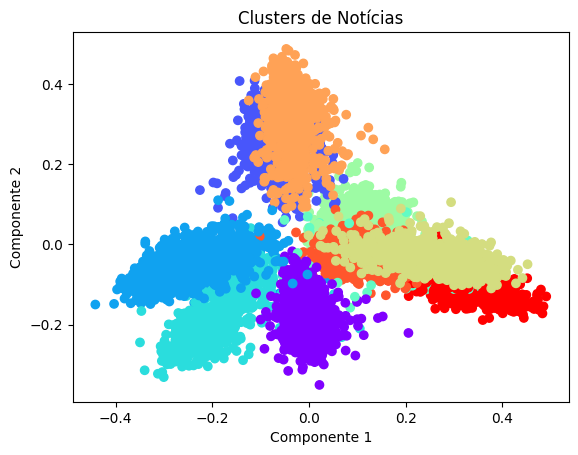

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.sparse import vstack

# Inicializando o TfidfVectorizer com 1000 features, pois o conjunto todo é muito grande e resulta em sobrecarga de memória 
vectorizer = TfidfVectorizer(max_features=1000)

# Processamento em partes menores (Chunking) para evitar sobrecarregar a memória.
chunk_size = 1000 
chunks = [df_clean['Text'][i:i + chunk_size] for i in range(0, df_clean.shape[0], chunk_size)]

# Cada parte é transformada usando o TfidfVectorizer.
tfidf_chunks = [vectorizer.fit_transform(chunk) for chunk in chunks]
x = vstack(tfidf_chunks)

# Utilizando o MiniBatchKMeans, que é uma variação de K-means projetada para trabalhar com grandes conjuntos de dados. 
# Ele processa os dados em mini-batches, reduzindo o uso de memória.
num_clusters = 10
kmeans = MiniBatchKMeans(n_clusters= num_clusters, random_state=0, batch_size=chunk_size).fit(x)

# # Adicionando os rótulos dos clusters ao DataFrame original
df_clean['Cluster'] = kmeans.labels_


# Visualizando os clusters com PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x.toarray())

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title('Clusters de Notícias')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
# plt.savefig('../images/clusterizacao_num10.png', dpi=300)
plt.show()

Classificação

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Separar as características e o alvo
# X contém o texto das notícias e y contém os rótulos (label).
x = df_clean['Text']
y = df_clean['label']

# Dividir em conjuntos de treino e teste
# Usa train_test_split para dividir os dados em conjuntos de treino e teste.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Inicializando o TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Transformar o texto em vetores TF-IDF
# Usa TfidfVectorizer para transformar o texto em vetores TF-IDF.
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Inicializando os modelos
modelos = {
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": make_pipeline(StandardScaler(with_mean=False), LinearDiscriminantAnalysis()),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Treinando e avaliando cada modelo
for name, modelo in modelos.items():
    if name == "Gaussian Naive Bayes":
        modelo.fit(x_train_tfidf.toarray(), y_train)  # GaussianNB requer entrada densa
        y_pred = modelo.predict(x_test_tfidf.toarray())
    else:
        modelo.fit(x_train_tfidf.toarray(), y_train)
        y_pred = modelo.predict(x_test_tfidf.toarray())
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'{name} Classifier:')
    print(f'Acurácia: {accuracy}')
    print('Relatório de Classificação:')
    print(report)
    print('-'*80)


#Treinar um modelo de Regressão Logística
# Inicializa e treina um modelo de Regressão Logística com os dados transformados.
# model = LogisticRegression()
# model.fit(x_train_tfidf, y_train)


# # Fazer previsões e avaliar o modelo
# # Faz previsões no conjunto de teste e avalia o modelo usando accuracy_score e classification_report.
# y_pred = model.predict(x_test_tfidf)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f'Acurácia: {accuracy}')
# print('Relatório de Classificação:')
# print(report)

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Carregar os dados
df_clean = pd.read_csv('../cleaned_data/cleaned_texts.csv')

# Separar as features e labels
X = df_clean['Text'].copy()
y = df_clean['label'].copy()

# Dividir os dados em conjuntos de treinamento e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.8, random_state=42)

# Converter o texto para vetores TF-IDF
vectorizer = TfidfVectorizer()
x_treino_tfidf = vectorizer.fit_transform(x_treino)
x_teste_tfidf = vectorizer.transform(x_teste)

# Verificar os rótulos presentes em y_teste
rotulos_unicos = y_teste.unique()
print(f"Rótulos únicos em y_teste: {rotulos_unicos}")


Rótulos únicos em y_teste: [0 1]


Acurácia Decision Tree: 0.9959595959595959
Precisão Decision Tree: 0.9984595635430038
Recall Decision Tree: 0.9933588761174968
F1 Score Decision Tree: 0.9959026888604353


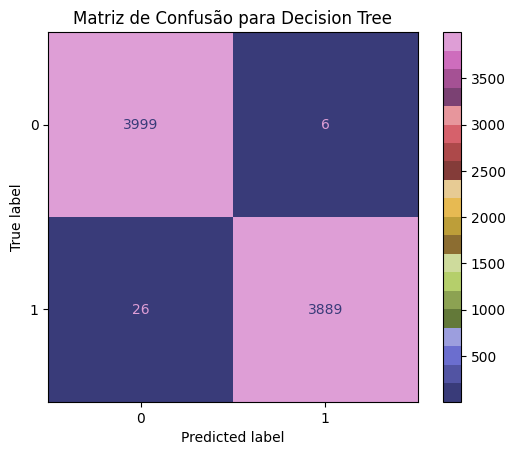

In [9]:
# Treinar o modelo Decision Tree
modelo_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=50, min_samples_leaf=10)
modelo_dt.fit(x_treino_tfidf, y_treino)

# Obter as características do TfidfVectorizer
nomes_caracteristicas = vectorizer.get_feature_names_out()

# Avaliar o modelo Decision Tree
y_teste_pred_dt = modelo_dt.predict(x_teste_tfidf)
acuracia_dt = accuracy_score(y_teste, y_teste_pred_dt)
precisao_dt = precision_score(y_teste, y_teste_pred_dt)
recall_dt = recall_score(y_teste, y_teste_pred_dt)
f1_dt = f1_score(y_teste, y_teste_pred_dt)

print(f"Acurácia Decision Tree: {acuracia_dt}")
print(f"Precisão Decision Tree: {precisao_dt}")
print(f"Recall Decision Tree: {recall_dt}")
print(f"F1 Score Decision Tree: {f1_dt}")

# Matriz de Confusão Decision Tree
cm_dt = confusion_matrix(y_teste, y_teste_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=rotulos_unicos)
disp_dt.plot(cmap='tab20b')
plt.title('Matriz de Confusão para Decision Tree')
# plt.savefig('../images/matriz_confusao_decision_tree.png', dpi=300)
plt.show()


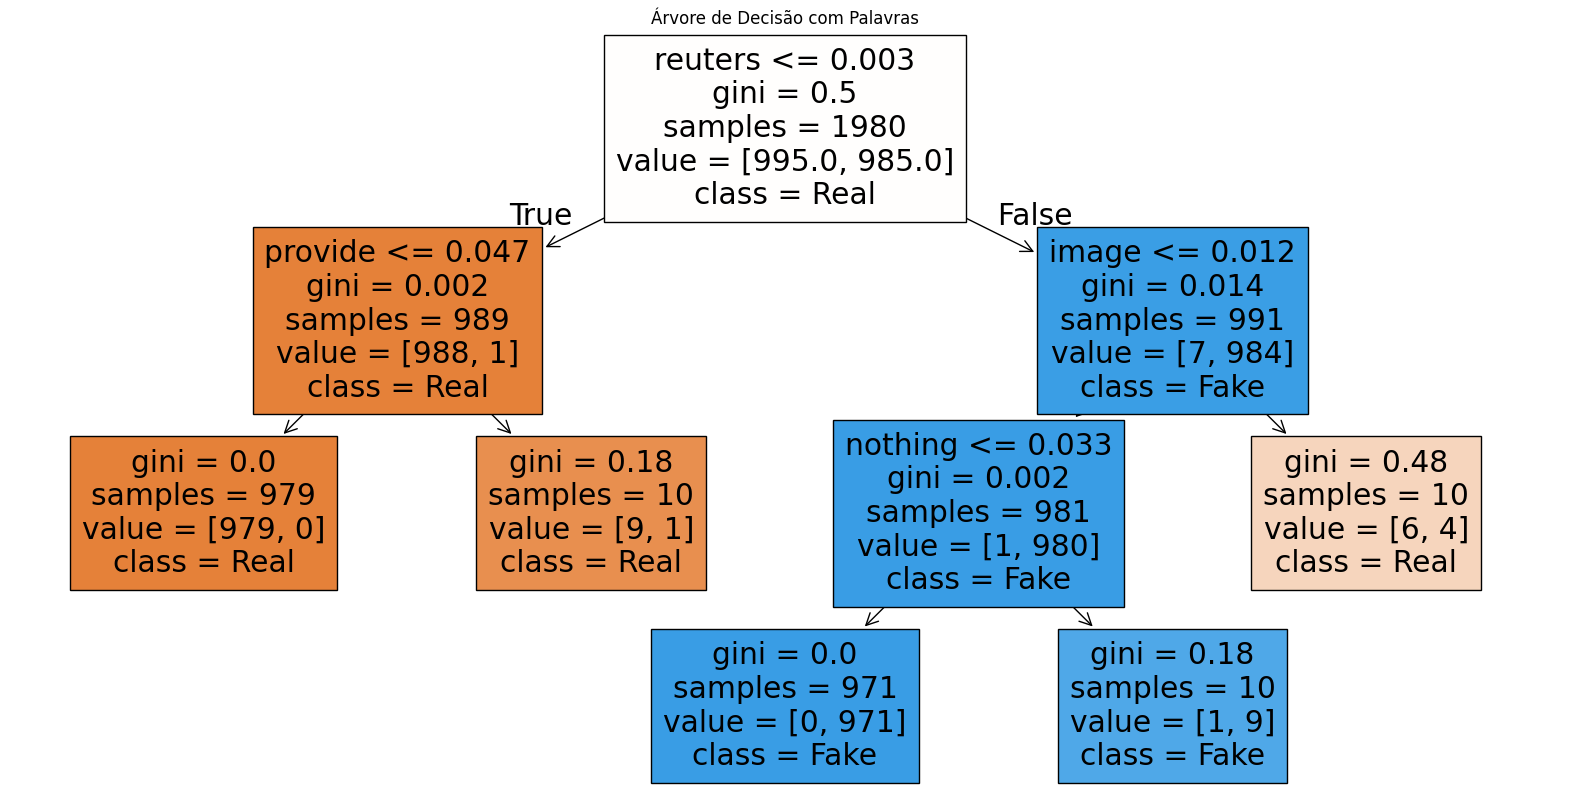

In [14]:
# Plotar a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(modelo_dt, feature_names=nomes_caracteristicas, class_names=['Real', 'Fake'], filled=True)
plt.title('Árvore de Decisão com Palavras')
plt.savefig('../images/arvore_decisao_com_palavras.png', dpi=300)
plt.show()

Acurácia Logistic Regression: 0.9959595959595959
Precisão Logistic Regression: 0.9950445986124876
Recall Logistic Regression: 0.997020854021847
F1 Score Logistic Regression: 0.996031746031746


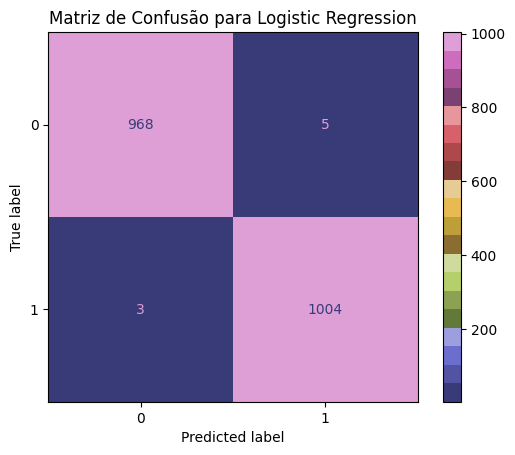

In [4]:
# Treinar o modelo Logistic Regression
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(x_treino_tfidf, y_treino)

# Avaliar o modelo Logistic Regression
y_teste_pred_lr = modelo_lr.predict(x_teste_tfidf)
acuracia_lr = accuracy_score(y_teste, y_teste_pred_lr)
precisao_lr = precision_score(y_teste, y_teste_pred_lr)
recall_lr = recall_score(y_teste, y_teste_pred_lr)
f1_lr = f1_score(y_teste, y_teste_pred_lr)

print(f"Acurácia Logistic Regression: {acuracia_lr}")
print(f"Precisão Logistic Regression: {precisao_lr}")
print(f"Recall Logistic Regression: {recall_lr}")
print(f"F1 Score Logistic Regression: {f1_lr}")

# Matriz de Confusão Logistic Regression
cm_lr = confusion_matrix(y_teste, y_teste_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=rotulos_unicos)
disp_lr.plot(cmap='tab20b')
plt.title('Matriz de Confusão para Logistic Regression')
plt.savefig('../images/matriz_confusao_logistic_regression.png', dpi=300)
plt.show()


Acurácia Naive Bayes: 0.9737373737373738
Precisão Naive Bayes: 0.9732408325074331
Recall Naive Bayes: 0.9751737835153923
F1 Score Naive Bayes: 0.9742063492063492


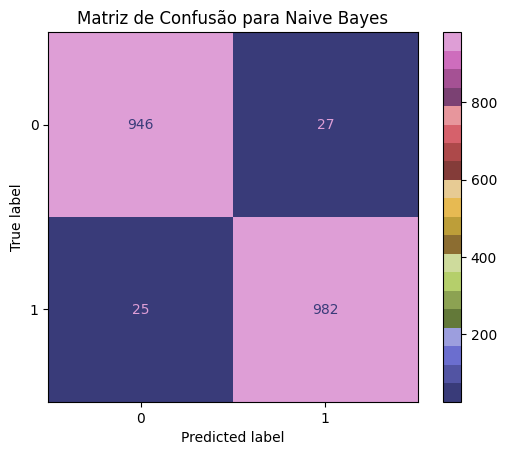

In [5]:
# Treinar o modelo Naive Bayes
modelo_nb = MultinomialNB()
modelo_nb.fit(x_treino_tfidf, y_treino)

# Avaliar o modelo Naive Bayes
y_teste_pred_nb = modelo_nb.predict(x_teste_tfidf)
acuracia_nb = accuracy_score(y_teste, y_teste_pred_nb)
precisao_nb = precision_score(y_teste, y_teste_pred_nb)
recall_nb = recall_score(y_teste, y_teste_pred_nb)
f1_nb = f1_score(y_teste, y_teste_pred_nb)

print(f"Acurácia Naive Bayes: {acuracia_nb}")
print(f"Precisão Naive Bayes: {precisao_nb}")
print(f"Recall Naive Bayes: {recall_nb}")
print(f"F1 Score Naive Bayes: {f1_nb}")

# Matriz de Confusão Naive Bayes
cm_nb = confusion_matrix(y_teste, y_teste_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=rotulos_unicos)
disp_nb.plot(cmap='tab20b')
plt.title('Matriz de Confusão para Naive Bayes')
plt.savefig('../images/matriz_confusao_naive_bayes.png', dpi=300)
plt.show()


In [ ]:
# Redução de Dimensionalidade com TruncatedSVD
svd = TruncatedSVD(n_components=200)  # Ajustar o número de componentes conforme necessário
x_treino_reduzido = svd.fit_transform(x_treino_tfidf)
x_teste_reduzido = svd.transform(x_teste_tfidf)

# Modelo 4: Linear Discriminant Analysis com Redução de Dimensionalidade
# Treinar o modelo Linear Discriminant Analysis
modelo_lda = LinearDiscriminantAnalysis()
modelo_lda.fit(x_treino_reduzido, y_treino)

# Avaliar o modelo Linear Discriminant Analysis
y_teste_pred_lda = modelo_lda.predict(x_teste_reduzido)
acuracia_lda = accuracy_score(y_teste, y_teste_pred_lda)
precisao_lda = precision_score(y_teste, y_teste_pred_lda)
recall_lda = recall_score(y_teste, y_teste_pred_lda)
f1_lda = f1_score(y_teste, y_teste_pred_lda)

print(f"Acurácia Linear Discriminant Analysis: {acuracia_lda}")
print(f"Precisão Linear Discriminant Analysis: {precisao_lda}")
print(f"Recall Linear Discriminant Analysis: {recall_lda}")
print(f"F1 Score Linear Discriminant Analysis: {f1_lda}")

# Matriz de Confusão Linear Discriminant Analysis
cm_lda = confusion_matrix(y_teste, y_teste_pred_lda)
disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=rotulos_unicos)
disp_lda.plot(cmap='tab20b')
plt.title('Matriz de Confusão para Linear Discriminant Analysis')
plt.savefig('../images/matriz_confusao_lda.png', dpi=300)
plt.show()

Acurácia K-Nearest Neighbors: 0.8570707070707071
Precisão K-Nearest Neighbors: 0.7981878088962109
Recall K-Nearest Neighbors: 0.9622641509433962
F1 Score K-Nearest Neighbors: 0.8725799189554255


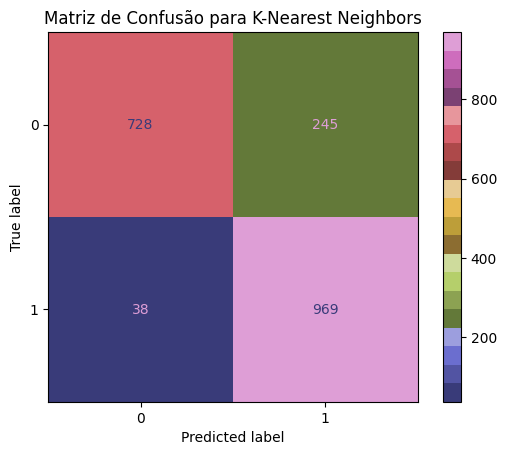

In [7]:
# Treinar o modelo K-Nearest Neighbors
modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(x_treino_tfidf.toarray(), y_treino)  # KNN precisa de matrizes densas

# Avaliar o modelo K-Nearest Neighbors
y_teste_pred_knn = modelo_knn.predict(x_teste_tfidf.toarray())
acuracia_knn = accuracy_score(y_teste, y_teste_pred_knn)
precisao_knn = precision_score(y_teste, y_teste_pred_knn)
recall_knn = recall_score(y_teste, y_teste_pred_knn)
f1_knn = f1_score(y_teste, y_teste_pred_knn)

print(f"Acurácia K-Nearest Neighbors: {acuracia_knn}")
print(f"Precisão K-Nearest Neighbors: {precisao_knn}")
print(f"Recall K-Nearest Neighbors: {recall_knn}")
print(f"F1 Score K-Nearest Neighbors: {f1_knn}")

# Matriz de Confusão K-Nearest Neighbors
cm_knn = confusion_matrix(y_teste, y_teste_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=rotulos_unicos)
disp_knn.plot(cmap='tab20b')
plt.title('Matriz de Confusão para K-Nearest Neighbors')
# plt.savefig('../images/matriz_confusao_knn.png', dpi=300)
plt.show()


In [12]:
# first try decision tree
mod_dt = DecisionTreeClassifier(max_depth = 3, random_state = 1)
mod_dt.fit(x_train_tfidf.toarray(),y_train)
prediction=mod_dt.predict(x_test_tfidf.toarray())
print('The accuracy of the Decision Tree is',"{:.3f}".format(accuracy_score(prediction,y_test)))

The accuracy of the Decision Tree is 0.998


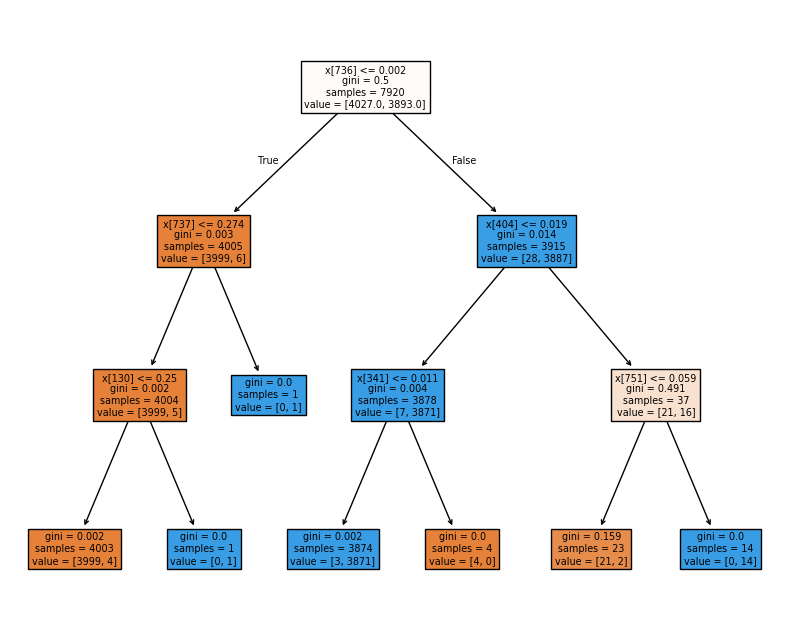

In [16]:
fn = ['Text']
plt.figure(figsize = (10,8))
plot_tree(mod_dt,  filled = True);

[[ 971    2]
 [   4 1003]]


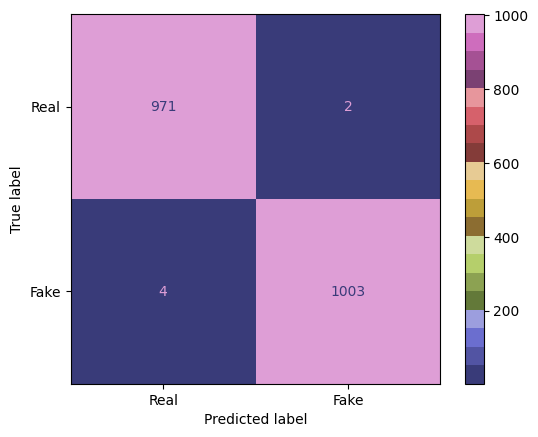

In [25]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

cn = ['Real', 'Fake']
cm = metrics.confusion_matrix(y_test, mod_dt.predict(x_test_tfidf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cn)
disp.plot(cmap='tab20b')
plt.savefig('../images/confusion_matrix1.png', dpi=300)
print(cm)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Métricas no conjunto de treinamento
y_train_pred = mod_dt.predict(x_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Métricas no conjunto de teste
y_test_pred = mod_dt.predict(x_test_tfidf)
acuracia_teste = accuracy_score(y_test, y_test_pred)
precisao_teste = precision_score(y_test, y_test_pred)
recall_teste = recall_score(y_test, y_test_pred)
f1_teste = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {acuracia_teste}")
print(f"Train Precision: {train_precision}, Test Precision: {precisao_teste}")
print(f"Train Recall: {train_recall}, Test Recall: {recall_teste}")
print(f"Train F1 Score: {train_f1}, Test F1 Score: {f1_teste}")


Train Accuracy: 0.9988636363636364, Test Accuracy: 0.9984848484848485
Train Precision: 0.9992287917737789, Test Precision: 0.998015873015873
Train Recall: 0.9984587721551502, Test Recall: 0.9990069513406157
Train F1 Score: 0.9988436335603238, Test F1 Score: 0.9985111662531018


In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(mod_dt, x_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")


Cross-Validation Accuracy Scores: [0.99431818 0.99558081 0.99810606 0.99936869 0.99747475]
Mean CV Accuracy: 0.9969696969696968


In [23]:
from sklearn.tree import DecisionTreeClassifier

# Ajustar os parâmetros da árvore
mod_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=50, min_samples_leaf=10)
mod_dt.fit(x_train_tfidf, y_train)

# Avaliar novamente o desempenho


DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=50)